# Trying Monte Carlo anaysis - RocketPy in Colab

# stuff you have to run every time

We start by setting up our environment. To run this notebook, we will need:


*   RocketPy
*   netCDF4 (to get weather forecasts)
*   Data files (we will clone RocketPy's repository for these)

Therefore, let's run the following lines of code:

In [ ]:
!pip install rocketpy netCDF4
!git clone https://github.com/giovaniceotto/RocketPy.git
!pip install plotly==5.14.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.5/129.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 92.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 93.4 MB/s eta 0:00:00
  Created wheel for simplekml: filename=simplekml-1.3.6-py3-none-any.whl size=65860 sha256=9218cf4a56b9e4034f20b9b0b72ddaaadf46eea924176f7be2442db77530b69c
  Stored in directory: /root/.cache/pip/wheels/16/7c/e6/621a95f24bd1ff987368f1c37881ffe013433ff6b413d87fcb
Successfully built simplekml
Cloning into 'RocketPy'...
remote: Enumerating objects: 11738, done.
remote: Counting objec

Now import the needed data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
os.chdir("RocketPy/docs/notebooks")


Now import the rest of the libraries

In [ ]:
from datetime import datetime
from time import process_time, perf_counter, time
import glob

from rocketpy import Environment, SolidMotor, Rocket, Flight, Function

import numpy as np
from numpy.random import normal, uniform, choice
from IPython.display import display



At the stuff from matplot lib


In [ ]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams["figure.figsize"] = [8, 5]
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["figure.titlesize"] = 14

In [ ]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

#Basic simulation of the rocket

## Weather data


To get weather data from the forecast, available online, we run the following lines.

First, we set tomorrow's date.

In [ ]:
import datetime

tomorrow = datetime.date.today() + datetime.timedelta(days=1)
date_info = (tomorrow.year, tomorrow.month, tomorrow.day, 12)  # Hour given in UTC time

Now we put in enveromental details Here we are using GEFS Ensemble which contains forcasts using mutliple differnt models



In [ ]:
Env = Environment(
    railLength=3, latitude=55.7268113, longitude=-4.8109188, elevation=243,
)
Env.setDate((tomorrow.year, tomorrow.month, tomorrow.day, 12))  # Hour given in UTC time

Env.setAtmosphericModel(type="Ensemble", file="GEFS")


By default, the 0th forecast member is activated, which means that using EnvGFS will be exactly the same as using the 0th forecast member, and all other forecasts are kept away stored. Changing this is as easy as the following line of code. Using .selectEnsembleMember will choice wich element to use for the data

A very useful thing is to compare the forecast of all ensemble members, as well as confirming how many are there. All of this can be done by using Environment.allInfo().

Gravity Details

Acceleration of Gravity: 9.80665 m/s²


Launch Site Details

Launch Rail Length: 3  m
Launch Date: 2023-06-06 12:00:00 UTC
Launch Site Latitude: 55.72681°
Launch Site Longitude: -4.81092°
Launch Site Surface Elevation: 243.0 m


Atmospheric Model Details

Atmospheric Model Type: Ensemble
Ensemble Maximum Height: 31.658 km
Ensemble Time Period: From  2023-06-05 06:00:00  to  2023-06-21 06:00:00  UTC
Ensemble Hour Interval: 6  hrs
Ensemble Latitude Range: From  -90.0 ° To  90.0 °
Ensemble Longitude Range: From  0.0 ° To  359.5 °
Number of Ensemble Members: 21
Selected Ensemble Member: 1  (Starts from 0)


Surface Atmospheric Conditions

Surface Wind Speed: 0.78 m/s
Surface Wind Direction: 20.06°
Surface Wind Heading: 187.99°
Surface Pressure: 997.49 hPa
Surface Temperature: 289.62 K
Surface Air Density: 1.200 kg/m³
Surface Speed of Sound: 341.16 m/s


Atmospheric Model Plots


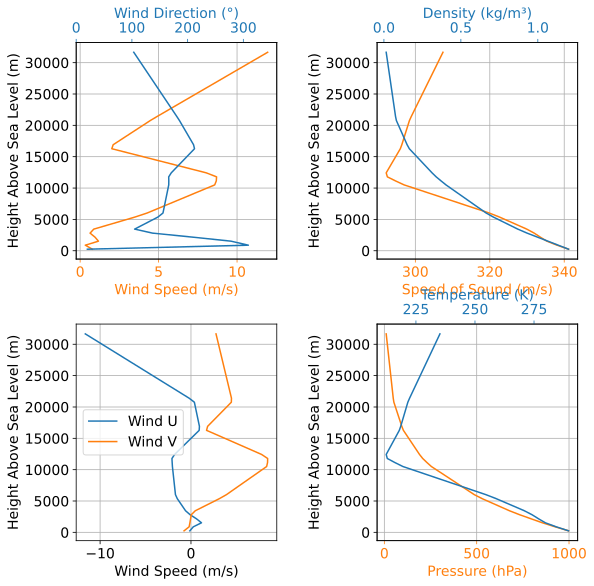



Ensemble Members Comparison


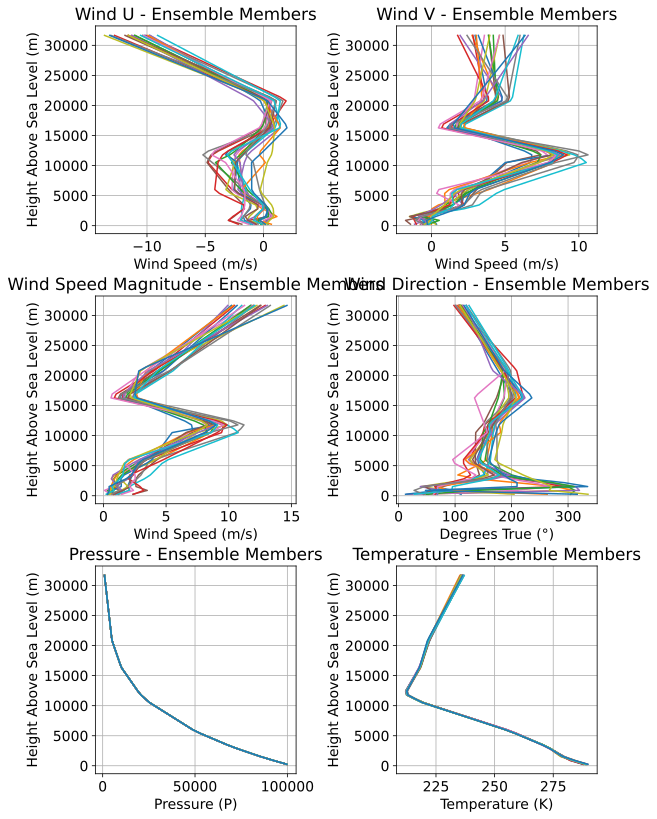

In [ ]:
Env.selectEnsembleMember(1)
Env.allInfo()


For the monte carlo sim Ill find the mean and variance for all the paramaters in the essemble

In [ ]:

#Taking averages
Envmean=Environment(
  railLength=3, latitude=55.7268113, longitude=-4.8109188, elevation=243,
)

print(np.shape(np.mean(Env.windUEnsemble, axis=1)))
Envmean.setAtmosphericModel(
  type="CustomAtmosphere",
)

Envmean.processCustomAtmosphere(
    wind_u =np.mean(Env.windUEnsemble, axis=1)
)

Envmean.setDate((tomorrow.year, tomorrow.month, tomorrow.day, 12))  # Hour given in UTC time


EnvSD = Environment(
  railLength=3, latitude=55.7268113, longitude=-4.8109188, elevation=243,
)

EnvSD.setAtmosphericModel(
  type="CustomAtmosphere",
  wind_u = np.std(Env.windUEnsemble, axis=0),
  wind_v = np.std(Env.windVEnsemble, axis=0),
  temperature = np.std(Env.temperatureEnsemble),
)
EnvSD.setDate((tomorrow.year, tomorrow.month, tomorrow.day, 12))  # Hour given in UTC time





NameError: ignored

## Creating a Motor

A solid rocket motor is used in this case. To create a motor, the SolidMotor class is used and the required arguments are given.

The SolidMotor class requires the user to have a thrust curve ready. This can come either from a .eng file for a commercial motor, such as below, or a .csv file from a static test measurement.

Besides the thrust curve, other parameters such as grain properties and nozzle dimensions must also be given.

In [ ]:
Pro75M1315 = SolidMotor(
    thrustSource="/content/drive/MyDrive/Upload/AeroTech_M1315W.eng",
    burnOut=5.4,
    grainNumber=5,
    grainSeparation=1.588 / 1000,
    grainDensity=1815,
    grainOuterRadius=34.63 / 1000,
    grainInitialInnerRadius=15 / 1000,
    grainInitialHeight=129.997 / 1000,
    nozzleRadius=23.8125 / 1000,
    throatRadius=8.699 / 1000,
    interpolationMethod="linear",
)

To see what our thrust curve looks like, along with other import properties, we invoke the info method yet again. You may try the allInfo method if you want more information all at once!


Motor Details
Total Burning Time: 5.949 s
Total Propellant Mass: 3.611 kg
Propellant Exhaust Velocity: 1840.447 m/s
Average Thrust: 1117.053 N
Maximum Thrust: 1728.683 N at 0.116 s after ignition.
Total Impulse: 6645.349 Ns

Plots


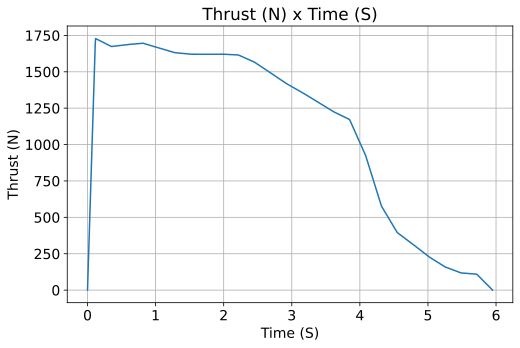

In [ ]:
Pro75M1315.info()

#Creating the rocket


Let's start by initializing our rocket, named Saltire, supplying it with the Pro75M1670 engine, entering its inertia properties, some dimensions and also its drag curves.

In [ ]:
Saltire = Rocket(
    motor=Pro75M1315,
    radius=127 / 2000,
    mass=17.280 - 5.645,
    inertiaI=4.78,
    inertiaZ=0.13,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag="/content/drive/MyDrive/Upload/CD Power Off RAS AERO1.csv",
    powerOnDrag="/content/drive/MyDrive/Upload/CD Power On RAS AERO1.csv",
)

Saltire.setRailButtons([0.2, -0.5])

##Adding Aerodynamic Surfaces

Now we define the aerodynamic surfaces. They are really straight forward.

In [ ]:
NoseCone = Saltire.addNose(length=0.6985, kind="vonKarman", distanceToCM=0.892)

FinSet = Saltire.addTrapezoidalFins(
    n=4,
    rootChord=0.14,
    tipChord=0.075,
    span=0.265,
    distanceToCM=-0.37,
    cantAngle=0,
    radius=None,
    airfoil=None,
)

Tail = Saltire.addTail(
    topRadius=0.1397, bottomRadius=0.0635, length=0.160, distanceToCM=-0.61
)

## Adding Parachutes

Finally, we have parachutes! Saltire will have two parachutes, Drogue and Main.

Both parachutes are activated by some special algorithm, which is usually really complex and a trade secret. Most algorithms are based on pressure sampling only, while some also use acceleration info.

RocketPy allows you to define a trigger function which will decide when to activate the ejection event for each parachute. This trigger function is supplied with pressure measurement at a predefined sampling rate. This pressure signal is usually noisy, so artificial noise parameters can be given. Call help(Rocket.addParachute) for more details. Furthermore, the trigger function also receives the complete state vector of the rocket, allowing us to use velocity, acceleration or even attitude to decide when the parachute event should be triggered.

Here, we define our trigger functions rather simply using Python. However, you can call the exact code which will fly inside your rocket as well.

In [ ]:
def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s which will occure at apogee.
    return True if y[5] < 0 else False


def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when -45 m/s < vz < -23 m/s and z < 450 + 110 m (+110 due to rough surface elevation of ponte del sol, 88.9 m for Fairly moor).
    return True if y[5] > -45 and y[5] < -23 and y[2] < 450 + 110 else False


Main = Saltire.addParachute(
    "Main",
   CdS=2.20 * 1.9151, #Cd * S (Cd = 2.2, S=(D/4)*pi = 2.4384pi/4)
      trigger=mainTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = Saltire.addParachute(
    "Drogue",
    CdS=1.5 * 0.3591, #Cd * S (Cd = 1.5, S=(D/4)*pi = 0.4572pi/4)
    trigger=drogueTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Just be careful if you run this last cell multiple times! If you do so, your rocket will end up with lots of parachutes which activate together, which may cause problems during the flight simulation. We advise you to re-run all cells which define our rocket before running this, preventing unwanted old parachutes. Alternatively, you can run the following lines to remove parachutes.

```python
Saltire.parachutes.remove(Drogue)
Saltire.parachutes.remove(Main)
```

In [ ]:
TestFlight = Flight(rocket=Saltire, environment=Env, inclination=85, heading=0)
TestFlight.info()

Surface Wind Conditions

Frontal Surface Wind Speed: -0.61 m/s
Lateral Surface Wind Speed: -0.22 m/s


 Rail Departure State

Rail Departure Time: 0.233 s
Rail Departure Velocity: 17.593 m/s
Rail Departure Static Margin: -0.637 c
Rail Departure Angle of Attack: 2.100°
Rail Departure Thrust-Weight Ratio: 11.499
Rail Departure Reynolds Number: 2.243e+00


BurnOut State

BurnOut time: 5.949 s
Altitude at burnOut: 1365.670 m (AGL)
Rocket velocity at burnOut: 287.120 m/s
Freestream velocity at burnOut: 287.219 m/s
Mach Number at burnOut: 0.852
Kinetic energy at burnOut: 4.796e+05 J


Apogee

Apogee Altitude: 3686.641 m (ASL) | 3443.641 m (AGL)
Apogee Time: 24.593 s
Apogee Freestream Speed: 6.705 m/s


Events

Drogue Ejection Triggered at: 24.600 s
Drogue Parachute Inflated at: 26.100 s
Drogue Parachute Inflated with Freestream Speed of: 14.424 m/s
Drogue Parachute Inflated at Height of: 3433.179 m (AGL)


Impact

X Impact: 33.125 m
Y Impact: 5.448 m
Time of Impact: 194.704 s
Velocity at Imp

# Monte Carlo flight simulation


## Setting up the sim

### choose the uncertain variables




From the docs:

The analysis parameters are a collection of expected values (and their uncertainties, or standard deviation) that completely defines a rocket flight. As an assumption, the parameters which define the flight can behave in 3 different ways: - the parameter is a completely known and has a constant value (i.e. number of fins) - the parameter can assume certain discrete values with uniform distribution (i.e. the member of an ensemble forecast, which might be any integer from 0 to 9) - the parameter is best represented by a normal (gaussian) distribution with a defined expected value and standard deviation

We implement this using a dictionary, where the key is the name of the parameter and the value is either a tuple or a list, depending on the behaviour of the parameter: - if the parameter is know, its value is represented as a list with a single entry (i.e. "number_of_fins: [4]") - if the parameter can assume certain discrete values with uniform distribution, its values are represented by a list of possible choices (i.e. "member_of_ensemble_forecast: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]") - if the parameter is best represented by a normal (gaussian) distribution, its value is a tuple with the expected value and its standard deviation (i.e. "rocket_mass": (100, 2), where 100 kg is the expected mass, with uncertainty of plus or minus 2 kg)

In [ ]:
analysis_parameters = {

  "ensembleMember": list(range(21)),  # Members of the ensemble forecast to be used
}

### Creating the random number generator

Now, we create a generator function which will yield all the necessary inputs for a single flight simulation. Each generated input will be randomly generated according to the analysis_parameters dicitionary set up above.

This is just a helper function to make the code clearer.

In [ ]:
def flight_settings(analysis_parameters, total_number):
    i = 0
    while i < total_number:
        # Generate a flight setting
        flight_setting = {}
        for parameter_key, parameter_value in analysis_parameters.items():
            if type(parameter_value) is tuple:
                flight_setting[parameter_key] = normal(*parameter_value)
            else:
                flight_setting[parameter_key] = choice(parameter_value)

        # Skip if certain values are negative, which happens due to the normal curve but isnt realistic
        #if flight_setting["lag_rec"] < 0 or flight_setting["lag_se"] < 0:
           # continue

        # Update counter
        i += 1
        # Yield a flight setting
        yield flight_setting

### Creating the export function

### Create permuntations file

Monte Carlo analyses usually contain data from thousands or tens of thousands of simulations. They can easily take hours to run. Therefore, it is very important to save our outputs to a file during the analysis. This way, if something happens, we do not lose our progress.

These next functions take care of that. They export the simulation data to three different files: - dispersion_input_file: A file where each line is a json converted dictionary of flight setting inputs to run a single trajectory simulation; - dispersion_output_file: A file where each line is a json converted dictionary containing the main outputs of a single simulation, such as apogee altitute and maximum velocity; - dispersion_error_file: A file to store the inputs of simulations which raised errors. This can help us debug these simulations later on.


Simulating a flight trajectory is as simple as initializing a Flight class object givin the rocket and environnement set up above as inputs. The launch rail inclination and heading are also given here.

In [ ]:
def export_flight_data(flight_setting, flight_data, exec_time):
    # Generate flight results
    flight_result = {
        "outOfRailTime": flight_data.outOfRailTime,
        "outOfRailVelocity": flight_data.outOfRailVelocity,
        "apogeeTime": flight_data.apogeeTime,
        "apogeeAltitude": flight_data.apogee - Env.elevation,
        "apogeeX": flight_data.apogeeX,
        "apogeeY": flight_data.apogeeY,
        "impactTime": flight_data.tFinal,
        "impactX": flight_data.xImpact,
        "impactY": flight_data.yImpact,
        "impactVelocity": flight_data.impactVelocity,
        "initialStaticMargin": flight_data.rocket.staticMargin(0),
        "outOfRailStaticMargin": flight_data.rocket.staticMargin(
            TestFlight.outOfRailTime
        ),
        "finalStaticMargin": flight_data.rocket.staticMargin(
            TestFlight.rocket.motor.burnOutTime
        ),
        "numberOfEvents": len(flight_data.parachuteEvents),
        "executionTime": exec_time,
    }

    # Calculate maximum reached velocity
    sol = np.array(flight_data.solution)
    flight_data.vx = Function(
        sol[:, [0, 4]], "Time (s)", "Vx (m/s)", "linear", extrapolation="natural"
    )
    flight_data.vy = Function(
        sol[:, [0, 5]], "Time (s)", "Vy (m/s)", "linear", extrapolation="natural"
    )
    flight_data.vz = Function(
        sol[:, [0, 6]], "Time (s)", "Vz (m/s)", "linear", extrapolation="natural"
    )
    flight_data.v = (
        flight_data.vx**2 + flight_data.vy**2 + flight_data.vz**2
    ) ** 0.5
    flight_data.maxVel = np.amax(flight_data.v.source[:, 1])
    flight_result["maxVelocity"] = flight_data.maxVel

    # Take care of parachute results
    if len(flight_data.parachuteEvents) > 0:
        flight_result["drogueTriggerTime"] = flight_data.parachuteEvents[0][0]
        flight_result["drogueInflatedTime"] = (
            flight_data.parachuteEvents[0][0] + flight_data.parachuteEvents[0][1].lag
        )
        flight_result["drogueInflatedVelocity"] = flight_data.v(
            flight_data.parachuteEvents[0][0] + flight_data.parachuteEvents[0][1].lag
        )
    else:
        flight_result["drogueTriggerTime"] = 0
        flight_result["drogueInflatedTime"] = 0
        flight_result["drogueInflatedVelocity"] = 0

    # Write flight setting and results to file
    dispersion_input_file.write(str(flight_setting) + "\n")
    dispersion_output_file.write(str(flight_result) + "\n")


def export_flight_error(flight_setting):
    dispersion_error_file.write(str(flight_setting) + "\n")

### Simulating each flight

(only run this if you have changed simulation paramater)

We start by defining the file name we want to use. Then, we specifiy how many simulations we would like to run by setting the number_of_simulations variable.

It is good practice to run something in the order of 100 simulations first, to check for any possible errors in the code. Once we are confident that everything is working well, we increase the number of simulations to something in the range of 5000 to 50000.

We will loop throught all flight settings, creating the environment, rocket and motor classes with the data of the analysis parameters. For the power off and on drag and thrust curve user should have in hands the .csv (or .eng for comercial motor’s thrust curve).

Tip: A better practice is openning the files in “append” mode, this way we can acumulate our simulations. To do this, just change the ‘a’ (write) argument of the open function in the third, fourth and fifth line of code to a (append).

In [ ]:
# Basic analysis info
filename = "/content/drive/MyDrive/Upload/" #put the path to where you saved the files here
number_of_simulations = 5
import datetime
# Create data files for inputs, outputs and error logging
dispersion_error_file = open(str(filename) + "disp_errors.txt", "w")
dispersion_input_file = open(str(filename) + "disp_inputs.txt", "w")
dispersion_output_file = open(str(filename) + "disp_outputs.txt", "w")

# Initialize counter and timer
i = 0

initial_wall_time = time()
initial_cpu_time = process_time()

# Define basic Environment object
Env = Environment(
    railLength=3, latitude=55.7268113, longitude=-4.8109188, elevation=243
)
Env.maxExpectedHeight = 1500

tomorrow = datetime.date.today() + datetime.timedelta(days=1)
Env.setDate((tomorrow.year, tomorrow.month, tomorrow.day, 12))  # Hour given in UTC time

Env.setAtmosphericModel(type="Ensemble", file="GEFS")

def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s which will occure at apogee.
    return True if y[5] < 0 else False


def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when -45 m/s < vz < -23 m/s and z < 450 + 110 m (+110 due to rough surface elevation of ponte del sol, 88.9 m for Fairly moor).
    return True if y[5] > -45 and y[5] < -23 and y[2] < 450 + 110 else False

# Iterate over flight settings
out = display("Starting", display_id=True)
for setting in flight_settings(analysis_parameters, number_of_simulations):
    start_time = process_time()
    i += 1

    # Update environment object
    Env.selectEnsembleMember(setting["ensembleMember"])

    # Create motor
    Pro75M1315 = SolidMotor(
      thrustSource="/content/drive/MyDrive/Upload/AeroTech_M1315W.eng",
      burnOut=5.4,
      grainNumber=5,
      grainSeparation=1.588 / 1000,
      grainDensity=1815,
      grainOuterRadius=34.63 / 1000,
      grainInitialInnerRadius=15 / 1000,
      grainInitialHeight=129.997 / 1000,
      nozzleRadius=23.8125 / 1000,
      throatRadius=8.699 / 1000,
      interpolationMethod="linear",
)

    # Create rocket
    Saltire = Rocket(
      motor=Pro75M1315,
      radius=127 / 2000,
      mass=17.280 - 5.645,
      inertiaI=4.78,
      inertiaZ=0.13,
      distanceRocketNozzle=-1.255,
      distanceRocketPropellant=-0.85704,
      powerOffDrag="/content/drive/MyDrive/Upload/CD Power Off RAS AERO1.csv",
      powerOnDrag="/content/drive/MyDrive/Upload/CD Power On RAS AERO1.csv",
  )

    Saltire.setRailButtons([0.2, -0.5])

    NoseCone = Saltire.addNose(length=0.6985, kind="vonKarman", distanceToCM=0.892)

    FinSet = Saltire.addTrapezoidalFins(
        n=4,
        rootChord=0.14,
        tipChord=0.075,
        span=0.265,
        distanceToCM=-0.37,
        cantAngle=0,
        radius=None,
        airfoil=None,
    )

    Tail = Saltire.addTail(
        topRadius=0.1397, bottomRadius=0.0635, length=0.160, distanceToCM=-0.61
    )

    Main = Saltire.addParachute(
        "Main",
      CdS=2.20 * 1.9151, #Cd * S (Cd = 2.2, S=(D/4)*pi = 2.4384pi/4)
          trigger=mainTrigger,
        samplingRate=105,
        lag=1.5,
        noise=(0, 8.3, 0.5),
    )

    Drogue = Saltire.addParachute(
        "Drogue",
        CdS=1.5 * 0.3591, #Cd * S (Cd = 1.5, S=(D/4)*pi = 0.4572pi/4)
        trigger=drogueTrigger,
        samplingRate=105,
        lag=1.5,
        noise=(0, 8.3, 0.5),
)
    # Run trajectory simulation
    try:
        TestFlight = Flight(rocket=Saltire, environment=Env, inclination=85, heading=0, maxTime=600,)
        export_flight_data(setting, TestFlight, process_time() - start_time)
    except Exception as E:
        print(E)
        export_flight_error(setting)

    # Register time
    out.update(
        f"Curent iteration: {i:06d} | Average Time per Iteration: {(process_time() - initial_cpu_time)/i:2.6f} s"
    )

# Done

## Print and save total time
final_string = f"Completed {i} iterations successfully. Total CPU time: {process_time() - initial_cpu_time} s. Total wall time: {time() - initial_wall_time} s"
out.update(final_string)
dispersion_input_file.write(final_string + "\n")
dispersion_output_file.write(final_string + "\n")
dispersion_error_file.write(final_string + "\n")

## Close files
dispersion_input_file.close()
dispersion_output_file.close()
dispersion_error_file.close()


'Completed 5 iterations successfully. Total CPU time: 27.151887931999994 s. Total wall time: 46.80524253845215 s'

## Monte Carlo simulation data anaysis

### Import the dispersion data

In [ ]:
filename = "/content/drive/MyDrive/Upload/"

# Initialize variable to store all results
dispersion_general_results = []

dispersion_results = {
    "outOfRailTime": [],
    "outOfRailVelocity": [],
    "apogeeTime": [],
    "apogeeAltitude": [],
    "apogeeX": [],
    "apogeeY": [],
    "impactTime": [],
    "impactX": [],
    "impactY": [],
    "impactVelocity": [],
    "initialStaticMargin": [],
    "outOfRailStaticMargin": [],
    "finalStaticMargin": [],
    "numberOfEvents": [],
    "maxVelocity": [],
    "drogueTriggerTime": [],
    "drogueInflatedTime": [],
    "drogueInflatedVelocity": [],
    "executionTime": [],
}

# Get all dispersion results
# Get file
dispersion_output_file = open(str(filename) + "disp_outputs.txt", "r+")

# Read each line of the file and convert to dict
for line in dispersion_output_file:
    # Skip comments lines
    if line[0] != "{":
        continue
    # Eval results and store them
    flight_result = eval(line)
    dispersion_general_results.append(flight_result)
    for parameter_key, parameter_value in flight_result.items():
        dispersion_results[parameter_key].append(parameter_value)

# Close data file
dispersion_output_file.close()

# Print number of flights simulated
N = len(dispersion_general_results)
print("Number of simulations: ", N)

Number of simulations:  5


### Graphing the Results



Altitude achived at Apogee

Apogee Altitude -         Mean Value: 3218.912 m
Apogee Altitude - Standard Deviation: 60.969 m


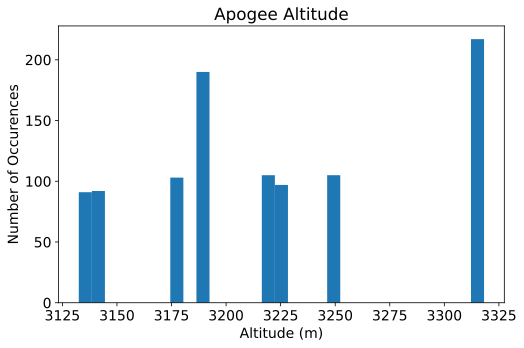

In [ ]:
print(
    f'Apogee Altitude -         Mean Value: {np.mean(dispersion_results["apogeeAltitude"]):0.3f} m'
)
print(
    f'Apogee Altitude - Standard Deviation: {np.std(dispersion_results["apogeeAltitude"]):0.3f} m'
)

plt.figure()
plt.hist(dispersion_results["apogeeAltitude"], bins=int(N**0.5))
plt.title("Apogee Altitude")
plt.xlabel("Altitude (m)")
plt.ylabel("Number of Occurences")
plt.show()


Impact position X cordinate


Impact X Position -         Mean Value: -713.605 m
Impact X Position - Standard Deviation: 317.466 m


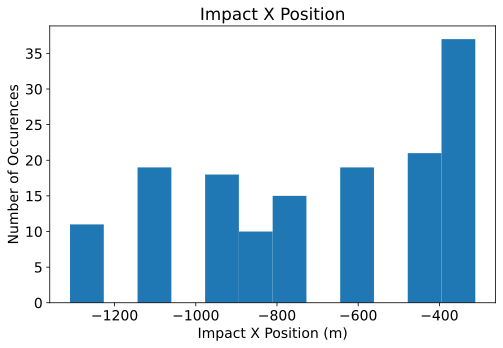

In [ ]:
print(
    f'Impact X Position -         Mean Value: {np.mean(dispersion_results["impactX"]):0.3f} m'
)
print(
    f'Impact X Position - Standard Deviation: {np.std(dispersion_results["impactX"]):0.3f} m'
)

plt.figure()
plt.hist(dispersion_results["impactX"], bins=int(N**0.5))
plt.title("Impact X Position")
plt.xlabel("Impact X Position (m)")
plt.ylabel("Number of Occurences")
plt.show()

Impact position Y cordinate


Impact Y Position -         Mean Value: 2692.777 m
Impact Y Position - Standard Deviation: 239.459 m


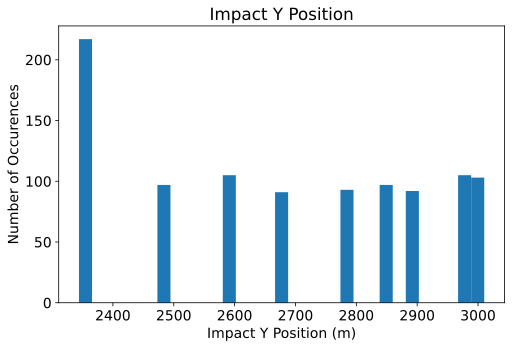

In [ ]:
print(
    f'Impact Y Position -         Mean Value: {np.mean(dispersion_results["impactY"]):0.3f} m'
)
print(
    f'Impact Y Position - Standard Deviation: {np.std(dispersion_results["impactY"]):0.3f} m'
)

plt.figure()
plt.hist(dispersion_results["impactY"], bins=int(N**0.5))
plt.title("Impact Y Position")
plt.xlabel("Impact Y Position (m)")
plt.ylabel("Number of Occurences")
plt.show()

error ellipses



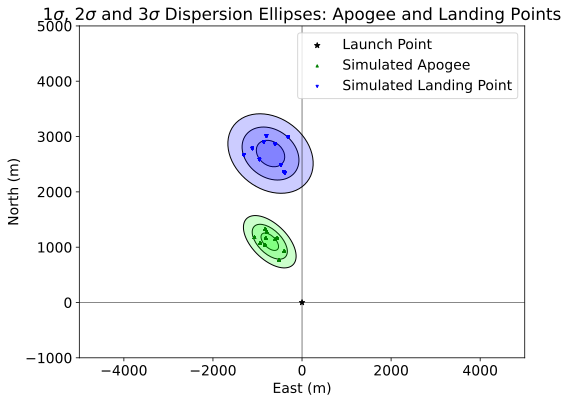

the mean impact coridnates are -707.3645110981612 2692.777387577349


In [ ]:
# Import libraries
from imageio import imread
from matplotlib.patches import Ellipse



# Retrieve dispersion data por apogee and impact XY position
apogeeX = np.array(dispersion_results["apogeeX"])
apogeeY = np.array(dispersion_results["apogeeY"])
impactX = np.array(dispersion_results["impactX"])
impactY = np.array(dispersion_results["impactY"])

# Define function to calculate eigen values
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]


# Create plot figure
plt.figure(num=None, figsize=(8, 6), dpi=150, facecolor="w", edgecolor="k")
ax = plt.subplot(111)

# Calculate error ellipses for impact
impactCov = np.cov(impactX, impactY)
impactVals, impactVecs = eigsorted(impactCov)
impactTheta = np.degrees(np.arctan2(*impactVecs[:, 0][::-1]))
impactW, impactH = 2 * np.sqrt(impactVals)

# Draw error ellipses for impact
impact_ellipses = []
for j in [1, 2, 3]:
    impactEll = Ellipse(
        xy=(np.mean(impactX), np.mean(impactY)),
        width=impactW * j,
        height=impactH * j,
        angle=impactTheta,
        color="black",
    )
    impactEll.set_facecolor((0, 0, 1, 0.2))
    impact_ellipses.append(impactEll)
    ax.add_artist(impactEll)

# Calculate error ellipses for apogee
apogeeCov = np.cov(apogeeX, apogeeY)
apogeeVals, apogeeVecs = eigsorted(apogeeCov)
apogeeTheta = np.degrees(np.arctan2(*apogeeVecs[:, 0][::-1]))
apogeeW, apogeeH = 2 * np.sqrt(apogeeVals)

# Draw error ellipses for apogee
for j in [1, 2, 3]:
    apogeeEll = Ellipse(
        xy=(np.mean(apogeeX), np.mean(apogeeY)),
        width=apogeeW * j,
        height=apogeeH * j,
        angle=apogeeTheta,
        color="black",
    )
    apogeeEll.set_facecolor((0, 1, 0, 0.2))
    ax.add_artist(apogeeEll)

# Draw launch point
plt.scatter(0, 0, s=30, marker="*", color="black", label="Launch Point")
# Draw apogee points
plt.scatter(apogeeX, apogeeY, s=5, marker="^", color="green", label="Simulated Apogee")
# Draw impact points
plt.scatter(
    impactX, impactY, s=5, marker="v", color="blue", label="Simulated Landing Point"
)

plt.legend()

# Add title and labels to plot
ax.set_title(
    "1$\sigma$, 2$\sigma$ and 3$\sigma$ Dispersion Ellipses: Apogee and Landing Points"
)
ax.set_ylabel("North (m)")
ax.set_xlabel("East (m)")

# Add background image to plot
# You can translate the basemap by changing dx and dy (in meters)
dx = 0
dy = 0
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.xlim(-5000, 5000)
plt.ylim(-1000, 5000)

# Save plot and show result
plt.savefig(str(filename) + ".pdf", bbox_inches="tight", pad_inches=0)
plt.savefig(str(filename) + ".svg", bbox_inches="tight", pad_inches=0)
plt.show()

print("the mean impact coridnates are", np.mean(impactX),np.mean(impactY) )


In [ ]:
import plotly.express as px
import plotly.graph_objects as go
latitude=[55.7268113]
longitude=[-4.8109188]

apogeeX = np.array(dispersion_results["apogeeX"])
apogeeY = np.array(dispersion_results["apogeeY"])
impactX = np.array(dispersion_results["impactX"])
impactY = np.array(dispersion_results["impactY"])

#make the map
fig = px.scatter_mapbox(lat=latitude, lon=longitude, hover_name=None, hover_data=None, color_discrete_sequence=["fuchsia"], zoom=15, height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

#draw launch point
fig.add_trace(go.Scatter(x=latitude,y=longitude, mode='markers'))
#draw apogee points
fig = px.scatter_mapbox(data_frame=None, lat= apogeeX, lon=apogeeY, hover_name=None, hover_data=None, color_discrete_sequence=["green"] )


fig.show()



Export Flight Trajectory to a .kml file so it can be opened on Google Earth

In [ ]:
TestFlight.exportKML(
    fileName="../../data/trajectory.kml",
    extrude=True,
    altitudeMode="relativetoground",
)

File  ../../data/trajectory.kml  saved with success!


## Using Simulation for Design

Here, we go through a couple of examples which make use of RocketPy in cool ways to help us design our rocket.

### Dynamic Stability Analysis

Ever wondered how static stability translates into dynamic stability? Different static margins result in different dynamic behavior, which also depends on the rocket's rotational inertial.

Let's make use of RocketPy's helper class called Function to explore how the dynamic stability of Saltire varies if we change the fins span by a certain factor.

Simulating Rocket with Static Margin of -0.693->0.905 c
Simulation Completed at Time: 5.0000 s


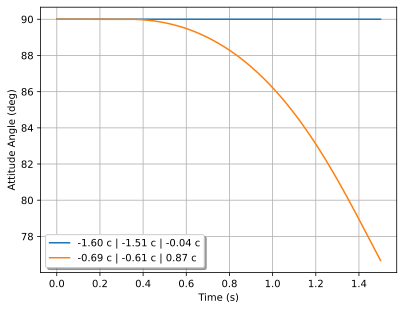

In [ ]:
    # Simulate
print(
        "Simulating Rocket with Static Margin of {:1.3f}->{:1.3f} c".format(
            Saltire.staticMargin(0), Saltire.staticMargin(Saltire.motor.burnOutTime)
      )
    )
TestFlight = Flight(
        rocket=Saltire,
        environment=Env,
        inclination=90,
        heading=0,
        maxTimeStep=0.01,
        maxTime=5,
        terminateOnApogee=True,
        verbose=True,
    )
    # Post process flight data
    TestFlight.postProcess()
    # Store Results
    staticMarginAtIgnition = Saltire.staticMargin(0)
    staticMarginAtOutOfRail = Saltire.staticMargin(TestFlight.outOfRailTime)
    staticMarginAtSteadyState = Saltire.staticMargin(TestFlight.tFinal)
    simulation_results += [
        (
            TestFlight.attitudeAngle,
            "{:1.2f} c | {:1.2f} c | {:1.2f} c".format(
                staticMarginAtIgnition,
                staticMarginAtOutOfRail,
                staticMarginAtSteadyState,
            ),
        )
    ]

Function.comparePlots(
    simulation_results,
    lower=0,
    upper=1.5,
    xlabel="Time (s)",
    ylabel="Attitude Angle (deg)",
)

In [ ]:
# Helper class
from rocketpy import Function

# Prepare Rocket Class
Saltire = Rocket(
    motor=Pro75M1670,
    radius=127 / 2000,
    mass=19.197 - 2.956,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag="../../data/Saltire/powerOffDragCurve.csv",
    powerOnDrag="../../data/Saltire/powerOnDragCurve.csv",
)
Saltire.setRailButtons([0.2, -0.5])
Nose = Saltire.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
FinSet = Saltire.addTrapezoidalFins(
    4, span=0.1, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
)
Tail = Saltire.addTail(
    topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
)

# Prepare Environment Class
Env = Environment(5.2, 9.8)
Env.setAtmosphericModel(type="CustomAtmosphere", wind_v=-5)

# Simulate Different Static Margins by Varying Fin Position
simulation_results = []

for factor in [0.5, 0.7, 0.9, 1.1, 1.3]:
    # Modify rocket fin set by removing previous one and adding new one
    Saltire.aerodynamicSurfaces.remove(FinSet)
    FinSet = Saltire.addTrapezoidalFins(
    4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956*factor
)
    # Simulate
    print(
        "Simulating Rocket with Static Margin of {:1.3f}->{:1.3f} c".format(
            Saltire.staticMargin(0), Saltire.staticMargin(Saltire.motor.burnOutTime)
        )
    )
    TestFlight = Flight(
        rocket=Saltire,
        environment=Env,
        inclination=90,
        heading=0,
        maxTimeStep=0.01,
        maxTime=5,
        terminateOnApogee=True,
        verbose=True,
    )
    # Post process flight data
    TestFlight.postProcess()
    # Store Results
    staticMarginAtIgnition = Saltire.staticMargin(0)
    staticMarginAtOutOfRail = Saltire.staticMargin(TestFlight.outOfRailTime)
    staticMarginAtSteadyState = Saltire.staticMargin(TestFlight.tFinal)
    simulation_results += [
        (
            TestFlight.attitudeAngle,
            "{:1.2f} c | {:1.2f} c | {:1.2f} c".format(
                staticMarginAtIgnition,
                staticMarginAtOutOfRail,
                staticMarginAtSteadyState,
            ),
        )
    ]

Function.comparePlots(
    simulation_results,
    lower=0,
    upper=1.5,
    xlabel="Time (s)",
    ylabel="Attitude Angle (deg)",
)

NameError: ignored

### Characteristic Frequency Calculation

Here we analyse the characteristic frequency of oscillation of our rocket just as it leaves the launch rail. Note that when we ran TestFlight.allInfo(), one of the plots already showed us the frequency spectrum of our flight. Here, however, we have more control of what we are plotting.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

Env = Environment(
    railLength=5.2, latitude=32.990254, longitude=-106.974998, elevation=1400
)

Env.setAtmosphericModel(type="CustomAtmosphere", wind_v=-5)

# Prepare Motor
Pro75M1670 = SolidMotor(
    thrustSource="../../data/motors/Cesaroni_M1670.eng",
    burnOut=3.9,
    grainNumber=5,
    grainSeparation=5 / 1000,
    grainDensity=1815,
    grainOuterRadius=33 / 1000,
    grainInitialInnerRadius=15 / 1000,
    grainInitialHeight=120 / 1000,
    nozzleRadius=33 / 1000,
    throatRadius=11 / 1000,
    interpolationMethod="linear",
)

# Prepare Rocket
Saltire = Rocket(
    motor=Pro75M1670,
    radius=127 / 2000,
    mass=19.197 - 2.956,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag="/Data/CD Power Off RAS AERO1.csv",
    powerOnDrag="/Data/CD Power On RAS AERO1.csv",
)

Saltire.setRailButtons([0.2, -0.5])

Nose = Saltire.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
FinSet = Saltire.addTrapezoidalFins(
    4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
)
Tail = Saltire.addTail(
    topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
)

# Simulate first 5 seconds of Flight
TestFlight = Flight(
    rocket=Saltire,
    environment=Env,
    inclination=90,
    heading=0,
    maxTimeStep=0.01,
    maxTime=5,
)
TestFlight.postProcess()

# Perform a Fourier Analysis
Fs = 100.0
# sampling rate
Ts = 1.0 / Fs
# sampling interval
t = np.arange(1, 400, Ts)  # time vector
ff = 5
# frequency of the signal
y = TestFlight.attitudeAngle(t) - np.mean(TestFlight.attitudeAngle(t))
n = len(y)  # length of the signal
k = np.arange(n)
T = n / Fs
frq = k / T  # two sides frequency range
frq = frq[range(n // 2)]  # one side frequency range
Y = np.fft.fft(y) / n  # fft computing and normalization
Y = Y[range(n // 2)]
fig, ax = plt.subplots(2, 1)
ax[0].plot(t, y)
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Signal")
ax[0].set_xlim((0, 5))
ax[1].plot(frq, abs(Y), "r")  # plotting the spectrum
ax[1].set_xlabel("Freq (Hz)")
ax[1].set_ylabel("|Y(freq)|")
ax[1].set_xlim((0, 5))
plt.subplots_adjust(hspace=0.5)
plt.show()

### Apogee as a Function of Mass

This one is a classic one! We always need to know how much our rocket's apogee will change when our payload gets heavier.

In [ ]:
def apogee(mass):
    # Prepare Environment
    Env = Environment(
        railLength=5.2,
        latitude=32.990254,
        longitude=-106.974998,
        elevation=1400,
        date=(2018, 6, 20, 18),
    )

    Env.setAtmosphericModel(type="CustomAtmosphere", wind_v=-5)

    # Prepare Motor
    Pro75M1670 = SolidMotor(
        thrustSource="../../data/motors/Cesaroni_M1670.eng",
        burnOut=3.9,
        grainNumber=5,
        grainSeparation=5 / 1000,
        grainDensity=1815,
        grainOuterRadius=33 / 1000,
        grainInitialInnerRadius=15 / 1000,
        grainInitialHeight=120 / 1000,
        nozzleRadius=33 / 1000,
        throatRadius=11 / 1000,
        interpolationMethod="linear",
    )

    # Prepare Rocket
    Saltire = Rocket(
        motor=Pro75M1670,
        radius=127 / 2000,
        mass=mass,
        inertiaI=6.60,
        inertiaZ=0.0351,
        distanceRocketNozzle=-1.255,
        distanceRocketPropellant=-0.85704,
        powerOffDrag="../../data/Saltire/powerOffDragCurve.csv",
        powerOnDrag="../../data/Saltire/powerOnDragCurve.csv",
    )

    Saltire.setRailButtons([0.2, -0.5])
    Nose = Saltire.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
    FinSet = Saltire.addTrapezoidalFins(
        4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
    )
    Tail = Saltire.addTail(
        topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
    )

    # Simulate Flight until Apogee
    TestFlight = Flight(
        rocket=Saltire,
        environment=Env,
        inclination=85,
        heading=0,
        terminateOnApogee=True,
    )
    return TestFlight.apogee


apogeebymass = Function(apogee, inputs="Mass (kg)", outputs="Estimated Apogee (m)")
apogeebymass.plot(8, 20, 20)

### Out of Rail Speed as a Function of Mass

To finish off, lets make a really important plot. Out of rail speed is the speed our rocket has when it is leaving the launch rail. This is crucial to make sure it can fly safely after leaving the rail. A common rule of thumb is that our rocket's out of rail speed should be 4 times the wind speed so that it does not stall and become unstable.

In [ ]:
def speed(mass):
    # Prepare Environment
    Env = Environment(
        railLength=5.2,
        latitude=32.990254,
        longitude=-106.974998,
        elevation=1400,
        date=(2018, 6, 20, 18),
    )

    Env.setAtmosphericModel(type="CustomAtmosphere", wind_v=-5)

    # Prepare Motor
    Pro75M1670 = SolidMotor(
        thrustSource="../../data/motors/Cesaroni_M1670.eng",
        burnOut=3.9,
        grainNumber=5,
        grainSeparation=5 / 1000,
        grainDensity=1815,
        grainOuterRadius=33 / 1000,
        grainInitialInnerRadius=15 / 1000,
        grainInitialHeight=120 / 1000,
        nozzleRadius=33 / 1000,
        throatRadius=11 / 1000,
        interpolationMethod="linear",
    )

    # Prepare Rocket
    Saltire = Rocket(
        motor=Pro75M1670,
        radius=127 / 2000,
        mass=mass,
        inertiaI=6.60,
        inertiaZ=0.0351,
        distanceRocketNozzle=-1.255,
        distanceRocketPropellant=-0.85704,
        powerOffDrag="../../data/Saltire/powerOffDragCurve.csv",
        powerOnDrag="../../data/Saltire/powerOnDragCurve.csv",
    )

    Saltire.setRailButtons([0.2, -0.5])
    Nose = Saltire.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
    FinSet = Saltire.addTrapezoidalFins(
        4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
    )
    Tail = Saltire.addTail(
        topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
    )

    # Simulate Flight until Apogee
    TestFlight = Flight(
        rocket=Saltire,
        environment=Env,
        inclination=85,
        heading=0,
        terminateOnApogee=True,
    )
    return TestFlight.outOfRailVelocity


speedbymass = Function(speed, inputs="Mass (kg)", outputs="Out of Rail Speed (m/s)")
speedbymass.plot(8, 20, 20)